In [1]:
using MatrixLM
using DataFrames
using Random
using Plots
Random.seed!(1)

TaskLocalRNG()

# Part 1. General Simulation

For matrix linear model, let $Y$ be a n$\times$m response matrix, the model can be expressed as:

$$Y = XBZ^T+E $$

Where $X_{n \times p}$ is the matrix for main predictor and $Z_{m \times q}$ denote the matrix from extra knowledge.

$E_{n \times m}$ is the error term and $B_{p \times q}$ is the matrix for main and interaction effects.

For this demo, we will simulate a dataset.

First, construct a `RawData` object consisting of the response variable `Y` and row/column predictors `X` and `Z`. All three matrices must be passed in as 2-dimensional arrays. Note that the `contr` function can be used to set up treatment and/or sum contrasts for categorical variables stored in a DataFrame. By default, `contr` generates treatment contrasts for all specified categorical variables (`"treat"`). Other options include `"sum"` for sum contrasts, `"noint"` for treatment contrasts with no intercept, and `"sumnoint"` for sum contrasts with no intercept. 

## Data Generation

In [2]:
# Dimensions of matrices 
n = 100
m = 250

# Number of column covariates
q = 20

# Generate data with two categorical variables and 4 numerical variables.
X_df = hcat(DataFrame(catvar1=rand(1:5, n), catvar2=rand(["A", "B", "C"], n)), DataFrame(rand(n,4),:auto))

# Convert dataframe to predicton matrix
X = Matrix(contr(X_df, [:catvar1, :catvar2], ["treat", "sum"]))

p = size(X)[2]

10

In [3]:
X_df

,catvar1,catvar2,x1,x2,x3,x4
,Int64,String,Float64,Float64,Float64,Float64
1,1,A,0.462428,0.155668,0.251098,0.589267
2,2,C,0.611215,0.928079,0.299601,0.11415
3,4,A,0.96203,0.928506,0.677402,0.200676
4,4,A,0.338884,0.458014,0.112663,0.345292
5,5,B,0.319402,0.876368,0.246686,0.431121
6,1,B,0.0912716,0.798325,0.761577,0.95697
7,4,C,0.89696,0.106448,0.498046,0.361177
8,4,C,0.714033,0.128388,0.227456,0.637138
9,4,C,0.519449,0.470248,0.30433,0.600977


In [4]:
X

100×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0   1.0   0.0  0.462428   0.155668  0.251098   0.589267
 1.0  0.0  0.0  0.0   0.0   1.0  0.611215   0.928079  0.299601   0.11415
 0.0  1.0  0.0  0.0   1.0   0.0  0.96203    0.928506  0.677402   0.200676
 0.0  1.0  0.0  0.0   1.0   0.0  0.338884   0.458014  0.112663   0.345292
 0.0  0.0  1.0  0.0  -1.0  -1.0  0.319402   0.876368  0.246686   0.431121
 0.0  0.0  0.0  0.0  -1.0  -1.0  0.0912716  0.798325  0.761577   0.95697
 0.0  1.0  0.0  0.0   0.0   1.0  0.89696    0.106448  0.498046   0.361177
 0.0  1.0  0.0  0.0   0.0   1.0  0.714033   0.128388  0.227456   0.637138
 0.0  1.0  0.0  0.0   0.0   1.0  0.519449   0.470248  0.30433    0.600977
 0.0  0.0  0.0  0.0   1.0   0.0  0.914266   0.616543  0.314008   0.555287
 0.0  0.0  0.0  1.0   1.0   0.0  0.037347   0.260702  0.755382   0.0335637
 0.0  0.0  0.0  1.0  -1.0  -1.0  0.35286    0.944696  0.322645   0.738069
 1.0  0.0  0.0  0.0  -1.0  -1.0  0.853496   0.819419  0.0915618  0.209414
 ⋮             

Randomly generate some data for column covariates `Z` and response variable `Y`

In [5]:
Z = rand(m,q)
B = rand(-5:5,p,q)
E = randn(n,m)
Y = X*B*transpose(Z)+E

100×250 Matrix{Float64}:
  -1.12611      5.48832      8.14331  …    4.89008   -0.0925478   -0.795076
 -14.6302      -2.36293     -2.6292      -18.2977   -14.305      -10.8796
   4.76135      7.08866      6.60091       9.42986    5.0623      -1.46182
   2.80985      6.33554      4.21646      12.894      9.69007      2.70539
  -0.0898669    7.05281     10.4505       11.8627    -9.24414     -5.55023
   6.91328     10.6031      25.7458   …   10.8076     1.21526      7.51597
 -19.5679     -11.3266     -18.0022      -24.7372   -18.9635     -17.1309
 -18.6088     -10.7504     -14.2896      -21.3777   -19.4226     -15.5209
 -15.9414      -4.66543     -8.53629     -11.4444   -10.8934     -11.7042
   0.26306      3.92012      9.12796       6.95926   -1.94408     -2.85687
  13.6023       9.26027     15.1254   …   12.1095    13.8112       8.22061
   9.34621     13.4675      28.6577       10.0963     2.28462     10.2455
  -2.08242      3.52387      3.65818      -8.42003  -12.0374      -1.09957
   ⋮

Finally, using all the data we have to construct a RawData object. The usage of `RawData()` can be found in here.

In [6]:
# Construct a RawData object
dat = RawData(Response(Y), Predictors(X, Z))

RawData(Response([-1.1261057628388147 5.488321777171364 … -0.09254775167280965 -0.7950761620566996; -14.630179712135842 -2.3629328517409585 … -14.30495769189562 -10.879557257587752; … ; 1.7971569602887394 3.359201054718633 … -8.467094261805894 -5.887300223928808; -3.6393912466812535 -2.687093484440372 … -17.128600037709294 -9.976225174158724]), Predictors([0.0 0.0 … 0.25109814442172873 0.589267068138644; 1.0 0.0 … 0.29960103249698744 0.1141499280802577; … ; 0.0 0.0 … 0.28953042830432585 0.033319039396518035; 0.0 0.0 … 0.6770898997246776 0.02500408833411838], [0.6944455272959528 0.5838256528504538 … 0.601302706760397 0.480612465664496; 0.6164038480415582 0.7900449846675524 … 0.11380203269928679 0.12804987242261967; … ; 0.8664576963075593 0.1577937632921802 … 0.8348714053116512 0.09632528333945622; 0.7309995847386772 0.9922758125870201 … 0.6828968233140088 0.305122782984216], false, false), 100, 250, 10, 20)

## Model Study

### Model construction

The matrix linear model could be build by using RawData object directly.

Least-squares estimates for matrix linear models can be obtained by running `mlm()`. An object of type `Mlm` will be returned, with variables for the coefficient estimates (`B`), the coefficient variance estimates (`varB`), and the estimated variance of the errors (`𝜎`). By default, `mlm` estimates both row and column main effects (`X` and `Z` intercepts), but this behavior can be suppressed by setting `hasXIntercept=false` and/or `hasZIntercept=false`. Column weights for `Y` and the target type for variance shrinkage can be optionally supplied to weights and targetType, respectively.

In [7]:
est = mlm(dat)

Mlm([-0.01480609256619357 -0.13767848816234976 … 0.0036003395572182925 -0.23386389760253998; -0.23039013378797746 4.094518009040962 … 1.1808782335048782 -4.887854740646702; … ; 0.06758849829378095 5.013132457273066 … -1.1055316740898808 -3.0406601501385357; 0.1053716503212172 -4.068574352189025 … -3.10572416631665 -2.81832636203012], [0.03970587082395105 0.00951150173460745 … 0.008331428487670267 0.007772315085707244; 0.02308605048973878 0.005530240357955592 … 0.004844114352026305 0.004519030933394371; … ; 0.024001053417012263 0.005749428396130613 … 0.005036108162926166 0.004698140241603375; 0.023565545024294303 0.005645102795235486 … 0.004944726033422002 0.00461289067068521], [1.088538580562074 0.05809360901201988 … -0.019235274399189473 0.08922572398006125; 0.05809360901201988 0.9549931540382722 … -0.02249862941865301 -0.096979928167091; … ; -0.019235274399189473 -0.02249862941865301 … 0.743856243040653 0.022340244749305873; 0.08922572398006125 -0.096979928167091 … 0.0223402447493058

### Model prediction and residuals

The coefficient estimates can be accessed using `coef(est)`. Predicted values and residuals can be obtained by calling `predict()` and `resid()`. By default, both of these functions use the same data used to fit the model. However, a new `Predictors` object can be passed into `predict()` as the `newPredictors` argument and a new `RawData` object can be passed into `resid()` as the newData argument. For convenience, `fitted(est)` will return the fitted values by calling predict with the default arguments.

In [8]:
size(B)

(10, 20)

In [9]:
esti_coef = coef(est)

11×21 Matrix{Float64}:
 -0.0148061  -0.137678    0.05299     …   0.0117064   0.00360034  -0.233864
 -0.23039     4.09452     0.99388        -0.97288     1.18088     -4.88785
  0.0487429  -2.94292    -5.00719         4.92993     1.01224     -3.90959
  0.0406441   0.0762493  -1.88874         5.01635    -2.00211     -0.979967
 -0.0407087   4.1666      3.06953         4.06108    -2.94325     -2.98198
  0.0044673  -1.0096      5.00068     …   3.01333    -1.0481      -1.01393
 -0.0883015   2.98511    -2.02381        -2.98537    -1.98832     -3.97098
  0.169242   -4.96929     0.0186324       2.96975    -2.90591     -4.83364
 -0.0679493  -3.8785     -1.10064         3.90863    -0.084463     2.00453
  0.0675885   5.01313     0.918518        1.11093    -1.10553     -3.04066
  0.105372   -4.06857     0.00812919  …   4.96739    -3.10572     -2.81833

In [10]:
preds = predict(est)

Response([0.29645427576143424 4.289214874240883 … -0.5028634296324312 -1.3522885625348648; -14.138711344176942 -3.7284967895198675 … -12.720051000137637 -10.309785724272862; … ; 0.7252867743212815 4.748110008397457 … -8.399703572123716 -5.362106174596653; -4.408515238373837 -1.5702472608831584 … -17.389454541796052 -11.042140509952162])

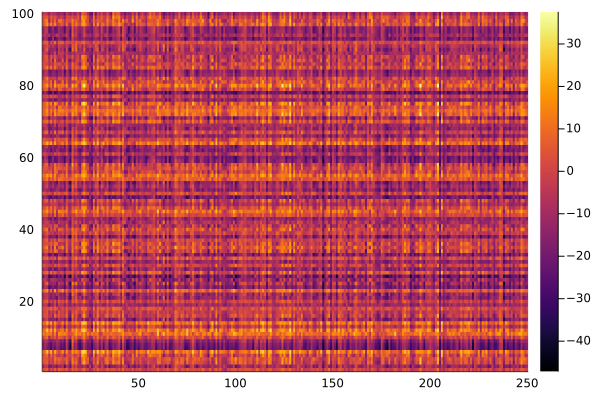

In [38]:
pred_y = reshape(preds.Y,250*100,1)
heatmap(preds.Y)

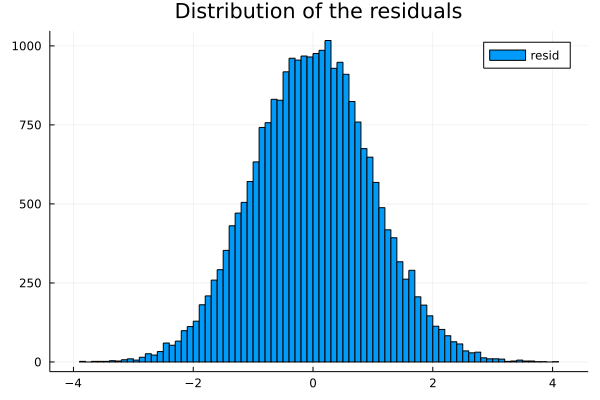

In [60]:
resids = resid(est)
histogram((reshape(resids,250*100,1)), title = "Distribution of the residuals", label = "resid")

### t-statistics and permutation test

The t-statistics for an `Mlm` object (defined as `est.B ./ sqrt.(est.varB)`) can be obtained by running `t_stat`. By default, `t_stat` does not return the corresponding t-statistics for any main effects that were estimated by `mlm`, but they will be returned if `isMainEff=true`. 


In [12]:
tStats = t_stat(est)

10×20 Matrix{Float64}:
  55.0593    15.5157    -13.7332  …  -13.4822   16.9667    -72.7102
 -43.2127   -85.3564    -61.2276      74.6016   15.8811    -63.506
   1.04613  -30.0836    -28.961       70.9267  -29.3495    -14.8734
  56.3955    48.2328     27.4123      56.6471  -42.5652    -44.6496
 -32.2053   185.189      68.339       99.0601  -35.7229    -35.7794
  96.4889   -75.9443    101.425   …  -99.4465  -68.6703   -141.992
 -64.0735     0.278908  -40.5377      39.4619  -40.0343    -68.9459
 -51.9953   -17.1299     15.8784      54.0004   -1.20985    29.7277
  66.1145    14.0632    -28.4093      15.099   -15.5784    -44.3614
 -54.151      0.125609   38.8427      68.1343  -44.1664    -41.4959

Permutation p-values for the t-statistics can be computed by the `mlm_perms` function. `mlm_perms` calls the more general function `perm_pvals` and will run the permutations in parallel when possible. The illustrative example below only runs 5 permutations, but a different number can be specified as the second argument. By default, the function used to permute `Y` is `shuffle_rows`, which shuffles the rows for `Y`. Alternative functions for permuting `Y`, such as `shuffle_cols`, can be passed into the argument `permFun`. `mlm_perms` calls `mlm` and `t_stat` , so the user is free to specify keyword arguments for `mlm` or `t_stat`; by default, `mlm_perms` will call both functions using their default behavior. 


In [13]:
nPerms = 5
tStats, pVals = mlm_perms(dat, nPerms)

([55.05931221489376 15.51565078819295 … 16.96672122743137 -72.71024931701572; -43.21273927384661 -85.35637668049156 … 15.881094031008715 -63.505952381113225; … ; 66.11451934043495 14.063176844415828 … -15.578429215966365 -44.36136430997428; -54.150981121284886 0.12560858243280124 … -44.16637589174753 -41.49585354221579], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.8 … 0.0 0.0])

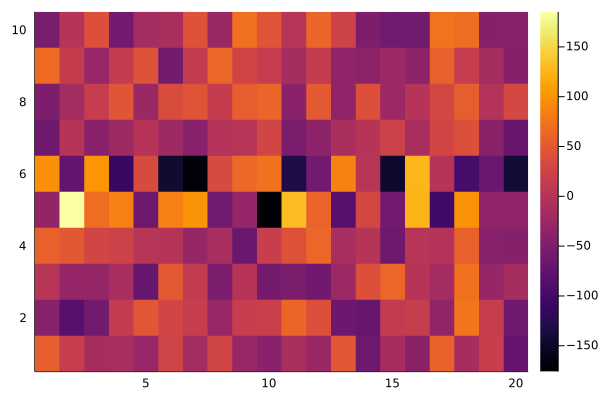

In [56]:
heatmap(tStats)

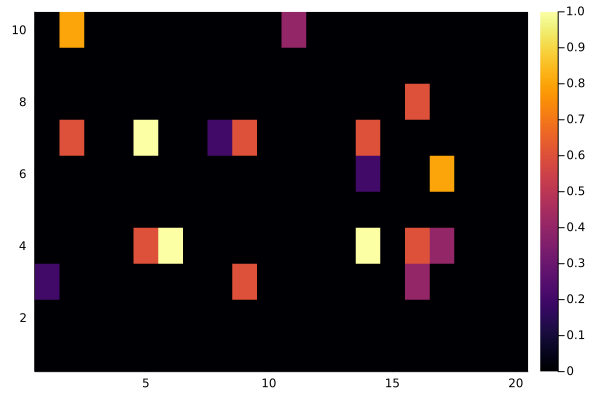

In [55]:
heatmap(pVals)

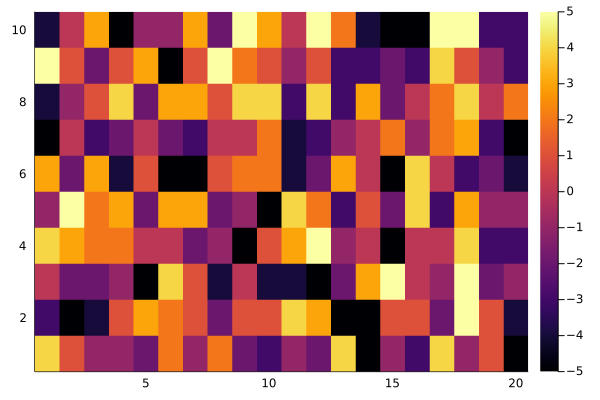

In [14]:
heatmap(B)

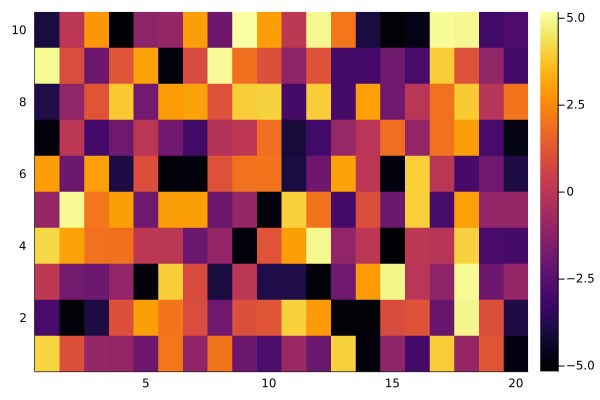

In [41]:
heatmap(esti_coef[1:end .!= 1, 1:end .!= 1])

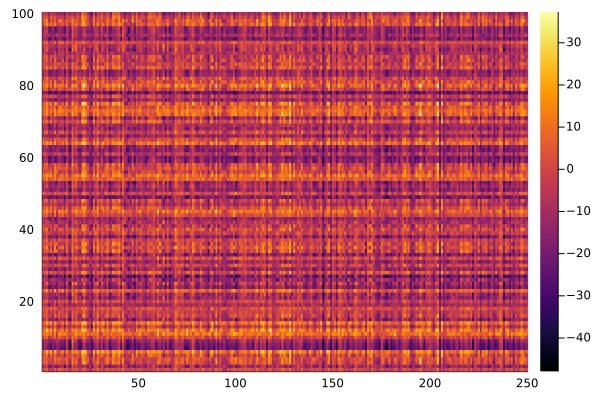

In [16]:
heatmap(Y)

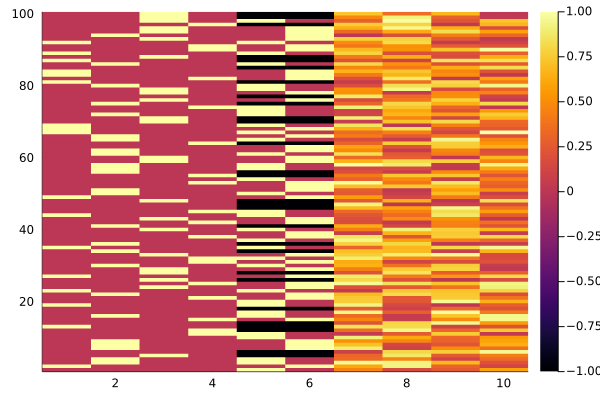

In [17]:
heatmap(X)

# Part 2. For ordinal variables

For this part our X matrix has only one ordinal variable(catvar1) from 1 to 5. The encoding method for ordinal variable is `SeqDiffCoding()` from package `StatsModels`

In [18]:
using StatsModels

In [19]:
levels = unique(X_df.catvar1)
encoding = StatsModels.ContrastsMatrix(SeqDiffCoding(), levels).matrix
encoding_intercept = inv(hcat(ones(5,1),encoding))

5×5 Matrix{Float64}:
  0.2   0.2   0.2   0.2   0.2
 -1.0   1.0  -0.0   0.0  -0.0
  0.0  -1.0   1.0   0.0  -0.0
  0.0   0.0  -1.0   1.0  -0.0
  0.0   0.0   0.0  -1.0   1.0

In [20]:
X2 = reduce(vcat,transpose.(map(x -> encoding_intercept[x,:], X_df.catvar1)))

100×5 Matrix{Float64}:
  0.2   0.2   0.2   0.2   0.2
 -1.0   1.0  -0.0   0.0  -0.0
  0.0   0.0  -1.0   1.0  -0.0
  0.0   0.0  -1.0   1.0  -0.0
  0.0   0.0   0.0  -1.0   1.0
  0.2   0.2   0.2   0.2   0.2
  0.0   0.0  -1.0   1.0  -0.0
  0.0   0.0  -1.0   1.0  -0.0
  0.0   0.0  -1.0   1.0  -0.0
  0.2   0.2   0.2   0.2   0.2
  0.0  -1.0   1.0   0.0  -0.0
  0.0  -1.0   1.0   0.0  -0.0
 -1.0   1.0  -0.0   0.0  -0.0
  ⋮                      
 -1.0   1.0  -0.0   0.0  -0.0
  0.0  -1.0   1.0   0.0  -0.0
  0.0  -1.0   1.0   0.0  -0.0
 -1.0   1.0  -0.0   0.0  -0.0
  0.0   0.0   0.0  -1.0   1.0
  0.0   0.0  -1.0   1.0  -0.0
  0.0   0.0   0.0  -1.0   1.0
  0.0   0.0   0.0  -1.0   1.0
  0.0  -1.0   1.0   0.0  -0.0
  0.0   0.0   0.0  -1.0   1.0
  0.0   0.0   0.0  -1.0   1.0
  0.0   0.0   0.0  -1.0   1.0

In [21]:
p = size(X2)[2]
n = 100
m = 250
q = 20

20

In [22]:
# Number of column covariates
Z2 = rand(m,q)
B2 = rand(-5:5,p,q)
E2 = randn(n,m)
Y2 = X2*B2*transpose(Z2)+E2

100×250 Matrix{Float64}:
 -0.55404    -0.468249    7.3416    …   4.90075     3.35738      4.43282
  7.10464     6.2802     -0.711716      1.20867     1.10932     11.6243
  5.63843    -3.86965   -15.1285        1.75613     5.99167     -8.78197
  6.11693    -7.10529   -15.9373        3.78264     5.47551    -11.5594
 -9.08839   -16.5765    -12.2793       -2.88547    -3.95249     -9.88613
  0.776738    1.13169     7.45085   …   2.00754     5.57202      5.50309
  8.21171    -5.75894   -13.6767        1.59197     3.99383     -9.86174
  6.17203    -4.33571   -15.1819        2.68209     3.52269    -10.036
  8.02979    -5.6356    -13.0928        2.7307      5.43986    -10.0786
 -0.184575   -0.417868    6.60444       2.65539     4.70767      5.88443
 -7.27719    11.6145     15.421     …   0.619138   -1.97466      2.44045
 -6.19814    12.1219     15.4888        0.0485972  -2.33024      0.120253
  9.81107     3.99816    -0.550318      3.30734    -0.0330996    7.93248
  ⋮                           

In [23]:
dat2 = RawData(Response(Y2), Predictors(X2, Z2))

RawData(Response([-0.5540399022769634 -0.46824874520008763 … 3.357384418721093 4.432823833481714; 7.104643287706619 6.280202493531283 … 1.109322758746587 11.624254176424284; … ; -9.020714830057091 -16.160629676654857 … -3.316070450024376 -9.087080264841557; -7.230222434993386 -15.860198172025276 … -2.9790664756515683 -9.496388322703568]), Predictors([0.19999999999999996 0.20000000000000007 … 0.2 0.2; -1.0 1.0 … 0.0 -0.0; … ; 0.0 0.0 … -1.0 1.0; 0.0 0.0 … -1.0 1.0], [0.042964168399122094 0.0970817871638543 … 0.9399330755215842 0.6215692968572735; 0.2966484096381907 0.7463865911772452 … 0.15799858396088873 0.7353175343547386; … ; 0.5400524855101956 0.08705983367808312 … 0.21328241181154883 0.3536509663939651; 0.9957202161607287 0.8492059037001669 … 0.39901120176680493 0.9651103216658151], false, false), 100, 250, 5, 20)

In [24]:
est2 = mlm(dat2)

Mlm([-0.0007083906988821695 0.877961883960902 … -1.2306653743115434 1.2998896560988646; 0.23669219657678242 2.8835948764370913 … -0.2657346497341109 5.378062858499691; … ; -0.13491193942120538 -1.750376999266939 … -2.536085114025685 1.4200919922881712; -0.10860663399283521 -5.606691745599629 … 5.697647868798799 -6.919638161254553], [-2.329359034059455e12 -4.070236705456881e11 … -4.83502670645433e11 -3.3175748282315625e11; -2.3293590340594067e12 -4.0702367054567957e11 … -4.835026706454229e11 -3.3175748282314935e11; … ; -9.317436136237848e12 -1.6280946821827573e12 … -1.9340106825817375e12 -1.327029931292629e12; -2.0964231306535145e13 -3.663213034911201e12 … -4.3515240358089067e12 -2.985817345408413e12], [0.8650812093889817 -0.12142025661117735 … -0.061869467552035436 0.04605917802811898; -0.12142025661117735 0.7213457472712318 … 0.03626065533510777 0.0015657531583482865; … ; -0.061869467552035436 0.03626065533510777 … 1.1616570830547936 0.06075712866885024; 0.04605917802811898 0.00156575

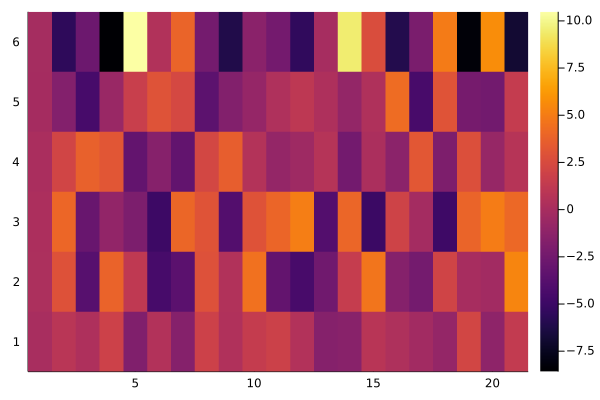

In [25]:
heatmap(coef(est2))

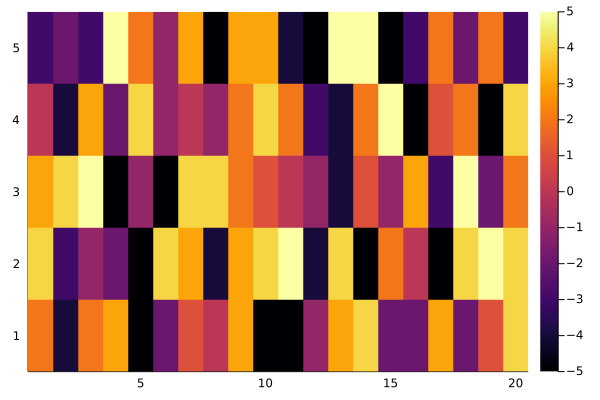

In [26]:
heatmap(B2)